# How to build a Graphene system with PBC?

In [1]:
import kwant
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.sparse.linalg as sla
import numpy as np

## Using the ancillary strategy

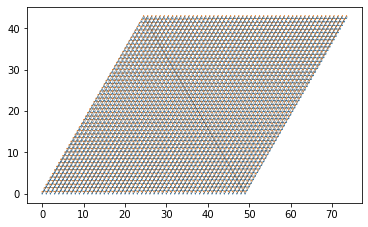

In [2]:
def make_system(e=0, t=1):
    lat = kwant.lattice.honeycomb()
    sym = kwant.TranslationalSymmetry(lat.vec((50, 0)), lat.vec((0, 50)))
#     sym = kwant.TranslationalSymmetry(lat.vec((0, 1)))

    # Build ancillary system with 2d periodic BCs.  This system cannot be
    # finalized in Kwant 1.0.
    anc = kwant.Builder(sym)
    anc[lat.shape(lambda p: True, (0, 0))] = None
    anc[lat.neighbors()] = None

    # Build a site-by-site and hopping-by-hopping copy of the ancillary system,
    # but this time without automatic PBCs.  This system can be finalized.
    sys = kwant.Builder()
    sys[anc.sites()] = e
    sys[((a, sym.to_fd(b)) for a, b in anc.hoppings())] = -t
    return sys

sys = make_system()
kwant.plot(sys);

In [3]:
fsystem = sys.finalized()
spectrum = kwant.kpm.SpectralDensity(fsystem)
# spectrum.add_vectors(500)

In [4]:
energies_subset = np.linspace(-1.5,1.5,201)
densities_subset = spectrum(energies_subset)
energies, densities = spectrum()

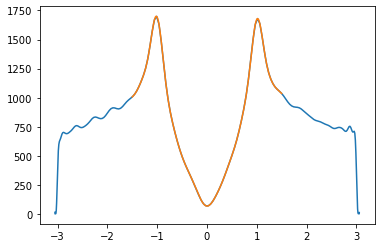

In [5]:
plt.plot(energies, densities.real)
plt.plot(energies_subset, densities_subset.real)

## The "by-hand" strategy

In [6]:
# Define the graphene lattice
sin_30, cos_30 = (1/2, np.sqrt(3)/2)
graphene = kwant.lattice.general([(1, 0), (sin_30, cos_30)],
                                 [(0, 0), (0, 1 / np.sqrt(3))],
                                 name='Graphene')

a, b = graphene.sublattices

In [7]:
def make_rect_system(W=10, L=20, pot=0.1, t=1):

    #### Define the scattering region. ####
    def rectangle(pos):
        x, y = pos
        return -W/2 < y < W/2 and -L/2 < x < L/2

    syst = kwant.Builder()
    syst[graphene.shape(rectangle, (0, 0))] = -pot

    # specify the hoppings of the graphene lattice in the
    # format expected by builder.HoppingKind
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -t
    
    return syst


def make_system(N1=10, N2=20, pot=0.1, t=1):

    #### Define the scattering region. ####
    syst = kwant.Builder()
    for a1 in range(N1):
        for a2 in range(N2):
            syst[a(a1, a2)] = -pot
            syst[b(a1, a2)] = -pot

    # specify the hoppings of the graphene lattice in the
    # format expected by builder.HoppingKind
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -t
    
    ## Horizontal hoppings PBC
    for j in range(1, N2):
        syst[a(N1-1, j), b(0,j-1)] = -t
    
    ## Vertical hopping PBC
    for i in range(N1):
        syst[b(i, N2-1), a(i, 0)] = -t
        syst[b((i+1) % N1, N2-1), a(i, 0)] = -t
    
    return syst

In [8]:
system = make_system(N1=50, N2=50)

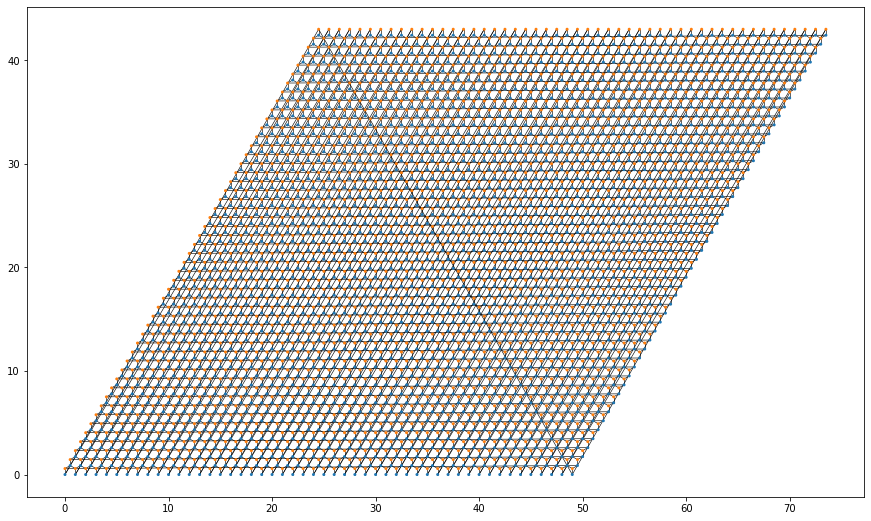

In [9]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
kwant.plot(system, ax=ax);

In [10]:
fsystem_hand_pbc = system.finalized()
spectrum = kwant.kpm.SpectralDensity(fsystem_hand_pbc)

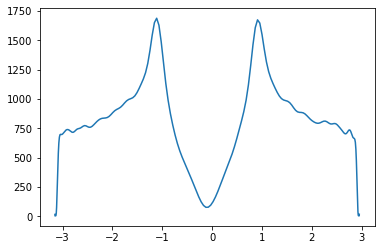

In [11]:
energies, densities = spectrum()
plt.plot(energies, densities.real)

In [12]:
system_rect = make_rect_system()

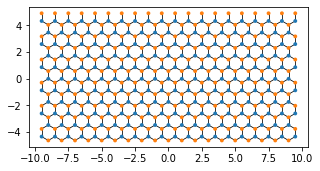

In [13]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_aspect('equal')
kwant.plot(system_rect, ax=ax);

## Wraparound strategy

In [150]:
a_lat = 1

lat = kwant.lattice.honeycomb(a=a_lat)

W = 6
L = 10
t = 1

def rect_pos(pos):
    x, y = pos
    return 0 <= x <= W and 0 <= y < L



# Infinite potential plane in y direction
syst = kwant.Builder(kwant.TranslationalSymmetry(lat.vec((0, W))))
syst[lat.shape(rect_pos, (0,0))] = 0

syst[lat.neighbors(1)] = -t
syst = kwant.wraparound.wraparound(syst)

print(lat.vec((0, W)))

[3.0 5.196152422706632]


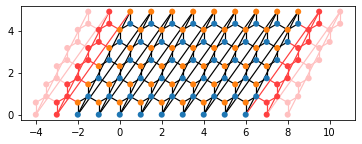

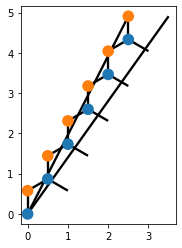

In [151]:
lead = kwant.Builder(kwant.TranslationalSymmetry(lat.vec((-1, 0)),
                                                 lat.vec((0, W))))

def lead_shape(pos):
    x, y = pos
    return 0 <= y <= W


lead[lat.shape(lead_shape, (0, 0))] = 0
lead[lat.neighbors(1)] = -t

lead = kwant.wraparound.wraparound(lead, keep=0)

syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

syst = syst.finalized()

kwant.plot(syst);
kwant.plot(lead);

In [126]:
# bands = kwant.physics.Bands(lead.finalized())

In [127]:
# kwant.plotter.bands(lead.finalized());

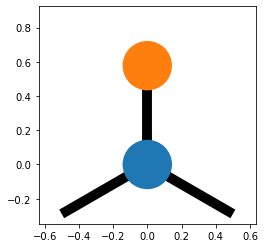

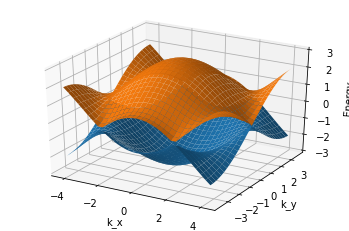

In [140]:
lead = kwant.Builder(kwant.TranslationalSymmetry(lat.vec((1, 0)),
                                                 lat.vec((0, 1))))

def lead_shape(pos):
    x, y = pos
    return 0 <= y <= W


lead[lat.shape(lead_shape, (0, 0))] = 0
lead[lat.neighbors(1)] = -t

kwant.plot(lead);

lead = kwant.wraparound.wraparound(lead, keep=None)

kwant.wraparound.plot_2d_bands(lead.finalized());

In [18]:
M = syst.hamiltonian_submatrix()

In [21]:
# Calculation
ky = -np.pi/2

energies = np.arange(0.1, 4.0, 0.1)
transmission = []
num_prop = []
for energy in energies:
#     smatrix = kwant.smatrix(syst, energy, params=dict(k_x=0, k_y=ky))
    smatrix = kwant.smatrix(syst, energy, args=[ky])
    transmission.append(smatrix.transmission(1, 0))
    num_prop.append(smatrix.num_propagating(0))

<ipython-input-21-f0e9f7c8224f>:9: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  smatrix = kwant.smatrix(syst, energy, args=[ky])
/home/marcos/anaconda3/envs/kwant/lib/python3.8/site-packages/kwant/solvers/common.py:162: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  lhs, norb = syst.hamiltonian_submatrix(args, sparse=True,
/home/marcos/anaconda3/envs/kwant/lib/python3.8/site-packages/kwant/solvers/common.py:191: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  prop, stab = lead.modes(energy, args, params=params)
/home/marcos/anaconda3/envs/kwant/lib/python3.8/site-packages/kwant/system.py:305: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1

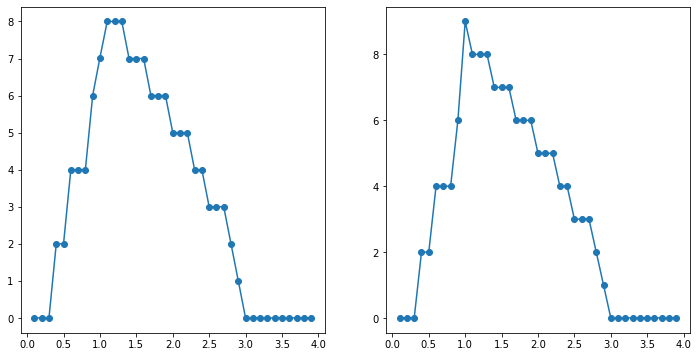

In [22]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(energies, transmission, '-o')

plt.subplot(122)
plt.plot(energies, num_prop, '-o')
plt.show()

<ipython-input-23-68b7be4245da>:4: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  wf = kwant.solvers.default.wave_function(syst, energy=.5,
/home/marcos/anaconda3/envs/kwant/lib/python3.8/site-packages/kwant/solvers/common.py:162: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  lhs, norb = syst.hamiltonian_submatrix(args, sparse=True,
/home/marcos/anaconda3/envs/kwant/lib/python3.8/site-packages/kwant/solvers/common.py:191: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  prop, stab = lead.modes(energy, args, params=params)
/home/marcos/anaconda3/envs/kwant/lib/python3.8/site-packages/kwant/system.py:305: KwantDeprecationWarning: The 'args' parameter has been deprecated since 

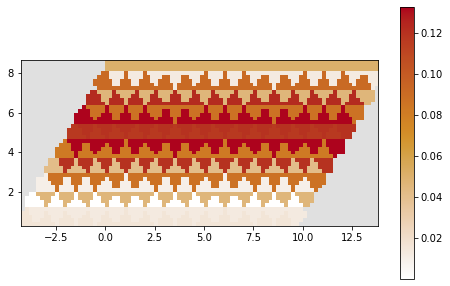

In [23]:
# wf = kwant.solvers.default.wave_function(syst, energy=.5,
#                                          params=dict(k_x=0, k_y=ky))

wf = kwant.solvers.default.wave_function(syst, energy=.5,
                                         args=[ky])

psi = wf(0)[0]

kwant.plotter.map(syst, np.abs(psi)**2, fig_size=(8,5));

In [84]:
def simple_syst(lat, E=0, t=1):
    """Create a builder for a simple infinite system."""
    sym = kwant.TranslationalSymmetry(lat.vec((1, 0)), lat.vec((0, 1)))
    # Build system with 2d periodic BCs. This system cannot be finalized in
    # Kwant <= 1.2.
    syst = kwant.Builder(sym)
    syst[lat.shape(lambda p: True, (0, 0))] = E
    syst[lat.neighbors(1)] = t
    return syst

In [87]:
graphene2d = kwant.wraparound.wraparound(simple_syst(lat)).finalized()

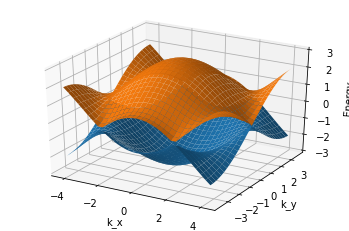

In [88]:
kwant.wraparound.plot_2d_bands(graphene2d);

## Comparison without wraparound

In [25]:
a_lat = 1

lat = kwant.lattice.honeycomb(a=a_lat)

W = 10
L = 10
t = 1

# Infinite potential plane in y direction
syst = kwant.Builder()
syst[lat.shape(rect_pos, (W/2, L/2))] = 0

syst[lat.neighbors(1)] = -t

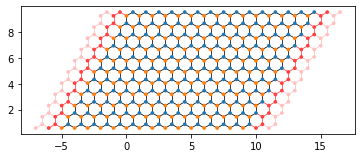

In [26]:
lead = kwant.Builder(kwant.TranslationalSymmetry((-a_lat, 0)))


lead[lat.shape(lead_shape, (0, W/2))] = 0
lead[lat.neighbors(1)] = -t

syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

syst = syst.finalized()

kwant.plot(syst);

In [27]:
# Calculation
# ky = -np.pi/2

energies = np.arange(0.1, 4.0, 0.1)
transmission = []
num_prop = []
for energy in energies:
    smatrix = kwant.smatrix(syst, energy, params=dict(k_x=0, k_y=ky))
    transmission.append(smatrix.transmission(1, 0))
    num_prop.append(smatrix.num_propagating(0))

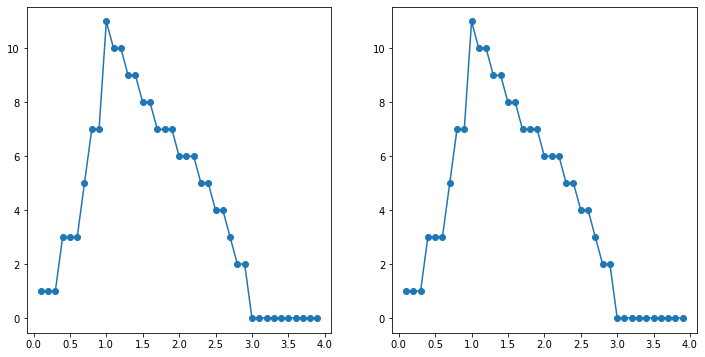

In [28]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(energies, transmission, '-o')

plt.subplot(122)
plt.plot(energies, num_prop, '-o')
plt.show()

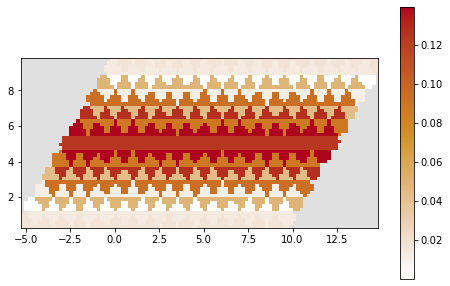

In [29]:
wf = kwant.solvers.default.wave_function(syst, energy=.5,
                                         params=dict(k_x=0, k_y=ky))

psi = wf(0)[0]

kwant.plotter.map(syst, np.abs(psi)**2, fig_size=(8,5));

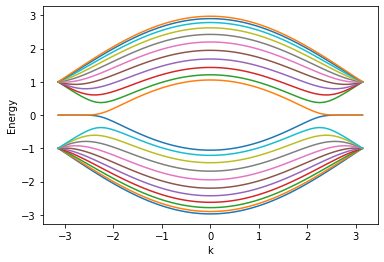

In [30]:
lead = kwant.Builder(kwant.TranslationalSymmetry((-a_lat, 0)))


lead[lat.shape(lead_shape, (0, W/2))] = 0
lead[lat.neighbors(1)] = -t

kwant.plotter.bands(lead.finalized());

## "Arm chair nanotube"

In [31]:
def make_graphene_strip(lat, W=4.5, L=20, V=0, t=1):
    
    #### Define the scattering region. ####
    def rectangle(pos):
        x, y = pos
        return 0 <= y < W and 0 <= x < L
   
    syst = kwant.Builder()
    syst[lat.shape(rectangle, (0, 0))] = V
    syst[lat.neighbors()] = -t
    
    return syst

def make_graphene_leads(lat, W=4.5, V=0, t=1):
    def lead_shape(pos):
        y = pos[1]
        return 0 <= y <= W
    
    symmetry = kwant.TranslationalSymmetry((-1,0))
    symmetry.add_site_family(lat.sublattices[0], other_vectors=[(-1,2)])
    symmetry.add_site_family(lat.sublattices[1], other_vectors=[(-1,2)])
    
    lead_0 = kwant.Builder(symmetry)
    lead_0[lat.shape(lead_shape, (0,0))] = V
    lead_0[lat.neighbors()] = -t
    
    lead_1 = lead_0.reversed()
    
    return [lead_0, lead_1]

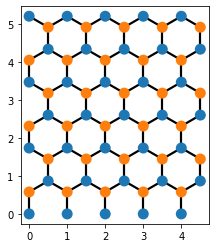

In [32]:
lat = kwant.lattice.honeycomb(a=1)
A, B = lat.sublattices

sistema = make_graphene_strip(lat, W=5.5, L=5)

kwant.plot(sistema);

In [33]:
for i in range(5):
    del sistema[A(i,0)]

sites = np.array([s.tag for s in sistema.sites() if s.family==A])
positions = np.array([s.pos for s in sistema.sites() if s.family==A])
families = np.array([s.family for s in sistema.sites()])

# np.sort(sites, axis=0)
# np.sort(positions, axis=0)
# families
# positions
# np.sort(positions, axis=0)
# print(sites.shape)

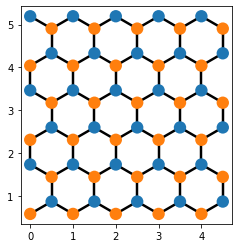

In [34]:
kwant.plot(sistema);

In [35]:
for i in range(5):
    sistema[A(i-3,6), B(i, 0)] = -t

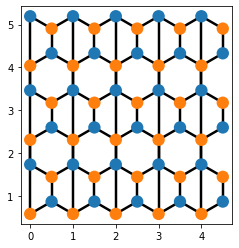

In [36]:
kwant.plot(sistema);

In [37]:
lat = kwant.lattice.honeycomb(a=1)
lead0, lead1 = make_graphene_leads(lat, W=5.5)

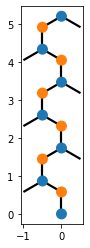

In [38]:
kwant.plot(lead0);

In [39]:
del lead0[A(0,0)]

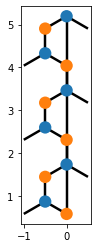

In [40]:
lead0[A(-3,6), B(0, 0)] = -t
kwant.plot(lead0);

In [41]:
for s in lead0.sites():
    print(s.tag)

[0 0]
[-1 1]
[-1 1]
[-1 2]
[-1 2]
[-2 3]
[-2 3]
[-2 4]
[-2 4]
[-3 5]
[-3 5]
[-3 6]


In [42]:
lead1 = lead0.reversed()

In [43]:
sistema.attach_lead(lead0);
sistema.attach_lead(lead1);

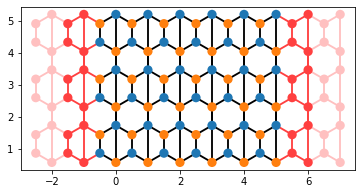

In [44]:
kwant.plot(sistema);

## Test for generalization

In [53]:
def W_to_close(W):
    N = max(W // np.sqrt(3), 2)
    return N * np.sqrt(3), int(N) 

def make_graphene_strip_test(lat, W=4.5, L=20, V=0, t=1, phi=0):
    
    W_new, N = W_to_close(W)
    #### Define the scattering region. ####
    def rectangle(pos):
        x, y = pos
        return 0 < y <= W_new and 0 <= x < L
   
    syst = kwant.Builder()
    syst[lat.shape(rectangle, (0, 0))] = V
    syst[lat.neighbors()] = -t
    
    sites_x_tags = [s.tag[0] for s in syst.sites() if s.family == B]
    M = max(sites_x_tags) + 1
    print(" N = {} \n M = {}".format(N, M))
    
    for i in range(M):
        syst[A(i-N, 2*N), B(i, 0)] = -t * np.exp(-1j*phi)
#     i = 2
#     syst[A(i-N, 2*N), B(i, 0)] = -t
    
    return syst

def make_graphene_leads_test(lat, W=4.5, V=0, t=1, phi=0):
    
    W_new, N = W_to_close(W)
    def lead_shape(pos):
        y = pos[1]
        return 0 < y <= W_new
    
    symmetry = kwant.TranslationalSymmetry((-1,0))
    symmetry.add_site_family(lat.sublattices[0], other_vectors=[(-1,2)])
    symmetry.add_site_family(lat.sublattices[1], other_vectors=[(-1,2)])
    
    lead_0 = kwant.Builder(symmetry)
    lead_0[lat.shape(lead_shape, (0,0))] = V
    lead_0[lat.neighbors()] = -t
    
    lead_0[A(-N, 2*N), B(0, 0)] = -t * np.exp(-1j*phi)
    
    lead_1 = lead_0.reversed()
    
    return [lead_0, lead_1]

 N = 5 
 M = 4


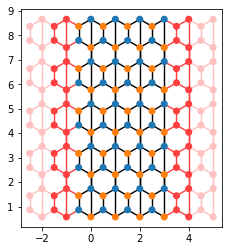

In [152]:
W_both = 10

lat = kwant.lattice.honeycomb(a=1)
A, B = lat.sublattices

Φ = 0

sistema_test = make_graphene_strip_test(lat, W=W_both, L=3.5, phi=Φ)
leads = make_graphene_leads_test(lat, W=W_both, phi=Φ)

for lead in leads:
    sistema_test.attach_lead(lead)

kwant.plot(sistema_test);

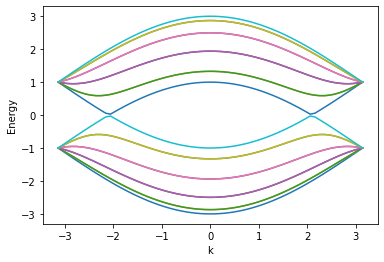

In [153]:
kwant.plotter.bands(leads[0].finalized());

In [154]:
def plot_bands_customized(lead):
    bands = kwant.physics.Bands(lead)
    momenta = np.linspace(-np.pi, np.pi, 201)
    energies = [bands(k) for k in momenta]
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(momenta, energies, color = 'k')

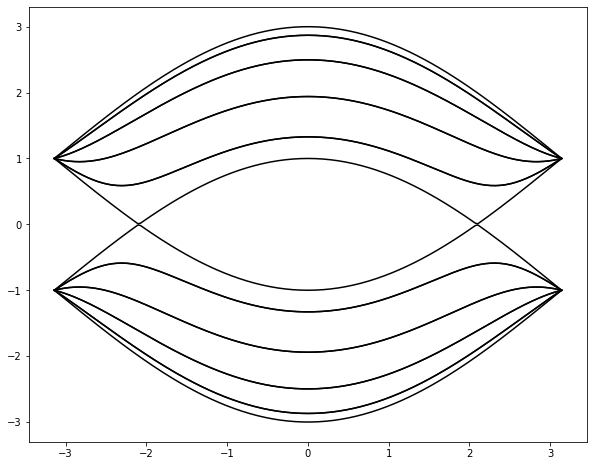

In [155]:
plot_bands_customized(leads[0].finalized())